# NETWORK ANALYSIS

In [1]:
import networkx as nx
import pandas as pd
from fa2 import ForceAtlas2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <font color="lightblue">Modelling the Network</font>

In [2]:
df_filepath = "Data/dataframe_characters_exploded.csv"
df = pd.read_csv(df_filepath)

df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [3]:
df

,index,Category,Links,Seasons
0,Andy Bernard,Main_Characters,Erin Hannon,"[3, 4, 5, 6, 7, 8, 9]"
1,Andy Bernard,Main_Characters,Angela Martin,"[3, 4, 5, 6, 7, 8, 9]"
2,Andy Bernard,Main_Characters,Unnamed Cousin,"[3, 4, 5, 6, 7, 8, 9]"
3,Andy Bernard,Main_Characters,Walter Bernard Jr.,"[3, 4, 5, 6, 7, 8, 9]"
4,Andy Bernard,Main_Characters,Walter Bernard Sr.,"[3, 4, 5, 6, 7, 8, 9]"
...,...,...,...,...
944,W.B. Jones,Other,Kevin Malone,[]
945,W.B. Jones,Other,Andy Bernard,[]
946,Wally Amos,Other,NaN,[]
947,Wesley Silver,Other,Robert Lipton,[9]


In [4]:
G = nx.from_pandas_edgelist(df=df, source='index', target='Links', create_using=nx.DiGraph())
G.remove_node(np.nan)

We can then use the <code>.from_pandas_edgelist()</code> function creates a directional graph with 'index' as nodes and 'Links' defining edges.

We only care about the "central network", i.e. external characters that have no relations to the main characters/plot are not relevant for our analysis. We remove them by finding the giant connected component.

In [10]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])
nx.readwrite.adjlist.write_adjlist(GCC,"Data/GCC.adjlist")

print(f"{len(G.nodes()) - len(GCC.nodes)} nodes removed")

74 nodes removed


In [10]:
print(f"Nodes in the network: {GCC.number_of_nodes()}")
print(f"Number of links in the network: {GCC.number_of_edges()}")

Nodes in the network: 221
Number of links in the network: 689


In [11]:
top_connected = sorted(GCC.degree, key=lambda x: x[1], reverse=True)[:1]
top_in = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[:1]
top_out = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[:15]

print("The top connected character in The Office is {} with {} in/out-degrees".format(top_connected[0][0], top_connected[0][1]))
print("The character most referenced in other pages in The Office is {} with {} in-degrees".format(top_in[0][0], top_in[0][1]))
print("The character with most references on its page to other characters in The Office is {} with {} out-degrees".format(top_out[0][0], top_out[0][1]))

The top connected character in The Office is Michael Scott with 74 in/out-degrees
The character most referenced in other pages in The Office is Michael Scott with 47 in-degrees
The character with most references on its page to other characters in The Office is Andy Bernard with 29 out-degrees


C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of outgoing edges')

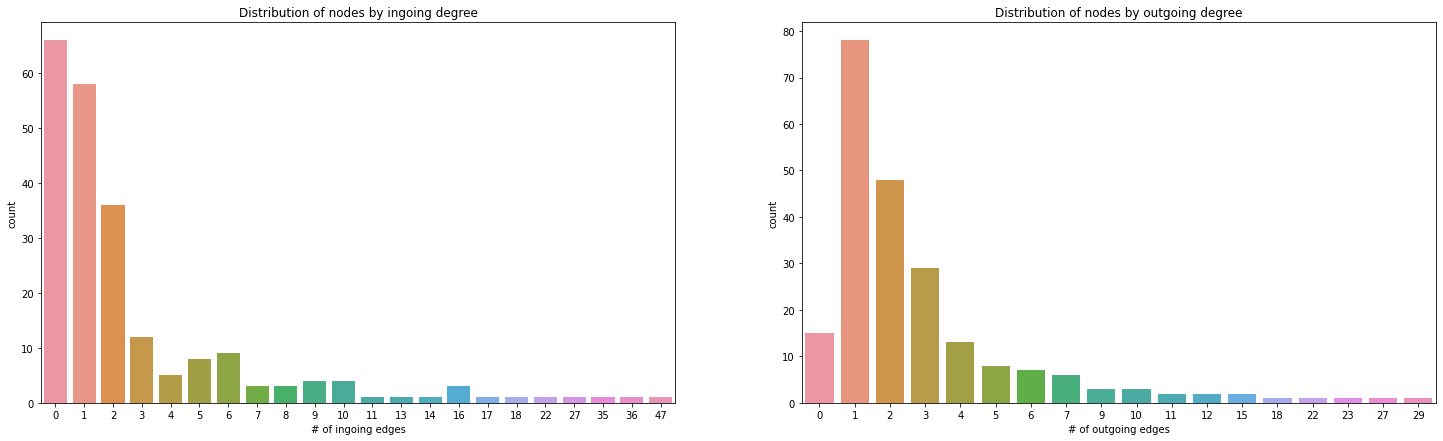

In [12]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes by ingoing degree")
axs[0].set_xlabel("# of ingoing edges")

sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes by outgoing degree")
axs[1].set_xlabel("# of outgoing edges")

In [23]:
# We convert to an undirected network
undirected_G = GCC.to_undirected()

# We remove self-loops 
undirected_G.remove_edges_from(nx.selfloop_edges(undirected_G))

undirected_G.remove_node("Mentioned characters")

In [14]:
characters = list(df['index'])
categories = list(df['Category'])
characters_categories_dict = dict(zip(characters, categories))

nx.set_node_attributes(GCC, characters_categories_dict, "Category")
nx.set_node_attributes(undirected_G, characters_categories_dict, "Category")

In [15]:
print([(x,y) for x,y in GCC.nodes(data=True)][:5])

[('Andy Bernard', {'Category': 'Main_Characters'}), ('Erin Hannon', {'Category': 'Main_Characters'}), ('Angela Martin', {'Category': 'Main_Characters'}), ('Unnamed Cousin', {'Category': 'Other'}), ('Walter Bernard Jr.', {'Category': 'Family_members'})]


In [16]:
# We define a color map for the roles
color_map = {'Main_Characters':'blue', 'Warehouse_worker':'black', 'Former_employees':'purple', 'Family_members':'red', "Other":'black', "Dunder_Mifflin_employees":"green", "Animals":"black", "Characters_of_Michael_Scott":"black", "Threat_Level_Midnight_Characters":"black", "Characters_of_Dwight_Schrute":"black", "The_3rd_Floor_Characters":"black", "Unseen_Characters":"black", "Unnamed":"black"}

In [24]:
colors = [color_map[undirected_G.nodes(data=True)[node]['Category']] for node in undirected_G.nodes()]

In [49]:
# We run Force Atlas 2 to get positions for the nodes

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(undirected_G, pos=None, iterations=5000)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 504.47it/s]

BarnesHut Approximation  took  1.95  seconds
Repulsion forces  took  7.12  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.36  seconds


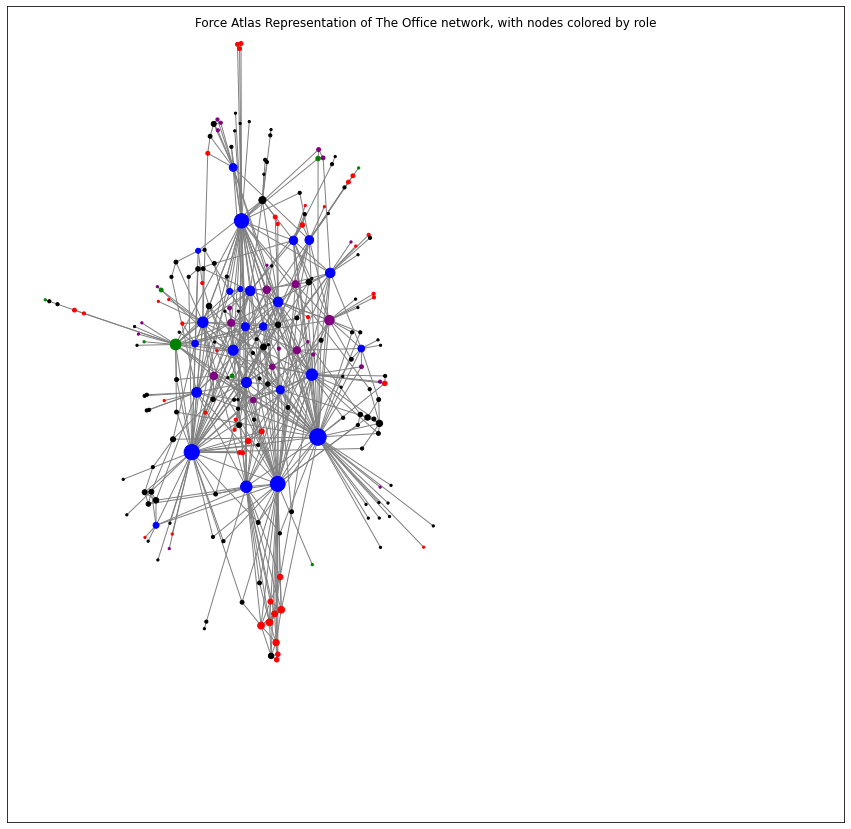

In [50]:
plt.figure(figsize=(15, 15))
plt.title("Force Atlas Representation of The Office network, with nodes colored by role", c='black',  y=1.0, pad=-20)
d = dict(undirected_G.degree)
nx.draw_networkx(undirected_G, positions, nodelist=list(d.keys()), node_size=[v*5 for v in d.values()], node_color = colors, with_labels=False, edge_color='grey')